In [ ]:
import os
import time
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageChops

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from skimage.morphology import binary_dilation, disk

import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

from lime import lime_image
import skfuzzy as fuzz


In [10]:
num_classes = 3

In [11]:
class ANFISLayer(nn.Module):
    def __init__(self, input_dim, num_rules=5):
        super(ANFISLayer, self).__init__()
        self.input_dim = input_dim
        self.num_rules = num_rules
        
        self.premise_params = nn.Parameter(torch.randn(num_rules, input_dim))
        self.consequent_params = nn.Parameter(torch.randn(num_rules, input_dim + 1))
        self.rule_weights = nn.Parameter(torch.ones(num_rules))
    
    def gaussian_membership(self, x, center, width):
        return torch.exp(-((x - center) ** 2) / (2 * width ** 2))
    
    def forward(self, x):
        batch_size = x.size(0)
        
        membership_degrees = []
        for r in range(self.num_rules):
            rule_membership = torch.ones(batch_size, device=x.device)
            for j in range(self.input_dim):
                center = self.premise_params[r, j]
                width = F.softplus(torch.abs(center))
                rule_membership *= self.gaussian_membership(x[:, j], center, width)
            membership_degrees.append(rule_membership)
        
        membership_degrees = torch.stack(membership_degrees, dim=1)
        rule_firing_strengths = membership_degrees / (membership_degrees.sum(1, keepdim=True) + 1e-8)
        
        rule_outputs = []
        for r in range(self.num_rules):
            rule_input = torch.cat([x, torch.ones(batch_size, 1, device=x.device)], dim=1)
            rule_output = torch.mm(rule_input, self.consequent_params[r].unsqueeze(1))
            rule_outputs.append(rule_output)
        
        rule_outputs = torch.cat(rule_outputs, dim=1)
        weighted_rule_outputs = rule_outputs * rule_firing_strengths
        final_output = weighted_rule_outputs.sum(1)
        
        return final_output

class HybridViTANFIS(nn.Module):
    def __init__(self, num_classes, cnn_backbone_name='mobilenetv3_large_100', vit_backbone_name='vit_base_patch16_224', num_anfis_rules=5):
        super(HybridViTANFIS, self).__init__()
        # Load backbone CNN
        self.cnn_backbone = timm.create_model(cnn_backbone_name, pretrained=True, features_only=True, out_indices=[4])
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            features = self.cnn_backbone(dummy_input)
        feature_dim = features[0].shape[1]
        
        # Load ViT model
        self.vit_backbone = timm.create_model(vit_backbone_name, pretrained=True)
        new_patch_embed = nn.Conv2d(feature_dim, self.vit_backbone.embed_dim, kernel_size=1, stride=1)
        self.vit_backbone.patch_embed = new_patch_embed
        
        # Lấy kích thước features một cách chính xác
        with torch.no_grad():
            features = self.cnn_backbone(dummy_input)
            feature_shape = features[0].shape
            H, W = feature_shape[2], feature_shape[3]
        
        num_patches = H * W
        self.vit_backbone.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, self.vit_backbone.embed_dim))
        
        # ANFIS Layer
        self.anfis_layer = ANFISLayer(input_dim=self.vit_backbone.embed_dim, num_rules=num_anfis_rules)
        
        # Final classification layer
        self.classifier = nn.Linear(self.vit_backbone.embed_dim, num_classes)
    
    def forward(self, x):
        # Feature extraction using CNN backbone
        cnn_features = self.cnn_backbone(x)
        x = self.vit_backbone.patch_embed(cnn_features[0])
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.vit_backbone.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.vit_backbone.pos_embed
        x = self.vit_backbone.blocks(x)
        x = self.vit_backbone.norm(x)
        
        # Extract CLS token features
        cls_features = x[:, 0]
        
        # Apply ANFIS Layer
        anfis_output = self.anfis_layer(cls_features)
        
        # Final classification
        final_output = self.classifier(cls_features + anfis_output.unsqueeze(1))
        
        return final_output


In [12]:
model = HybridViTANFIS(num_classes=num_classes, 
                       cnn_backbone_name='mobilenetv3_large_100', 
                       vit_backbone_name='vit_base_patch16_224',
                       num_anfis_rules=5)

In [13]:
train_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/train'
val_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/val'
test_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/test'
save_path = '/kaggle/working/vitmobiv3_4_RdC.pt'
save_best = '/kaggle/working/vitmobiv3_4_RdC_best.pt'

In [14]:
# Thiết lập tăng cường dữ liệu
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_vt = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [15]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_vt)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_vt)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HybridViTANFIS(
  (cnn_backbone): MobileNetV3Features(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Hardswish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): Id

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [18]:
def train(model, train_loader, val_loader, save_path, save_best, criterion, optimizer, num_epochs=5, patience=3):
    train_accs = []
    train_losss = []
    val_accs = []
    val_losss = []
    epochs_no_improve = 0
    best_loss= 5.0
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct = 0
        total = 0
        
        
        for inputs, labels in train_loader:
            # Đưa dữ liệu lên GPU nếu có
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reset gradient
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass và tối ưu
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_accuracy = correct / total * 100  # Tính toán accuracy

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f}% , Training Loss: {train_loss:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total * 100

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}% , Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            # Lưu mô hình nếu có cải thiện
            torch.save(model.state_dict(), save_best)
            print(f"Validation loss improved. Model saved to {save_best}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        # Kiểm tra nếu không có cải thiện qua nhiều epochs thì dừng
        if epochs_no_improve >= patience:
            torch.save(model.state_dict(), save_path)
            print(f"Early stopping at epoch {epoch+1} and save Last.")
            break
        
        train_accs.append(train_accuracy)
        train_losss.append(train_loss)
        val_accs.append(val_accuracy)
        val_losss.append(val_loss)
        
        model.train()
    return train_accs, train_losss, val_accs, val_losss, epoch

In [19]:
accs, losss, val_accs, val_losss, num_epochs=train(model, train_loader, val_loader, save_path, save_best, criterion, optimizer, 30)

Epoch [1/30], Training Accuracy: 63.85% , Training Loss: 0.9797
Epoch [1/30], Validation Accuracy: 92.00% , Validation Loss: 0.2855
Validation loss improved. Model saved to /kaggle/working/vitmobiv3_4_RdC_best.pt
Epoch [2/30], Training Accuracy: 94.96% , Training Loss: 0.1603
Epoch [2/30], Validation Accuracy: 97.09% , Validation Loss: 0.0851
Validation loss improved. Model saved to /kaggle/working/vitmobiv3_4_RdC_best.pt
Epoch [3/30], Training Accuracy: 97.79% , Training Loss: 0.0682
Epoch [3/30], Validation Accuracy: 97.73% , Validation Loss: 0.0755
Validation loss improved. Model saved to /kaggle/working/vitmobiv3_4_RdC_best.pt
Epoch [4/30], Training Accuracy: 98.09% , Training Loss: 0.0613
Epoch [4/30], Validation Accuracy: 98.18% , Validation Loss: 0.0584
Validation loss improved. Model saved to /kaggle/working/vitmobiv3_4_RdC_best.pt
Epoch [5/30], Training Accuracy: 98.32% , Training Loss: 0.0531
Epoch [5/30], Validation Accuracy: 97.82% , Validation Loss: 0.0697
No improvement i

In [20]:
def visualize_results(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(20, 15))
    
    # 1. Learning Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

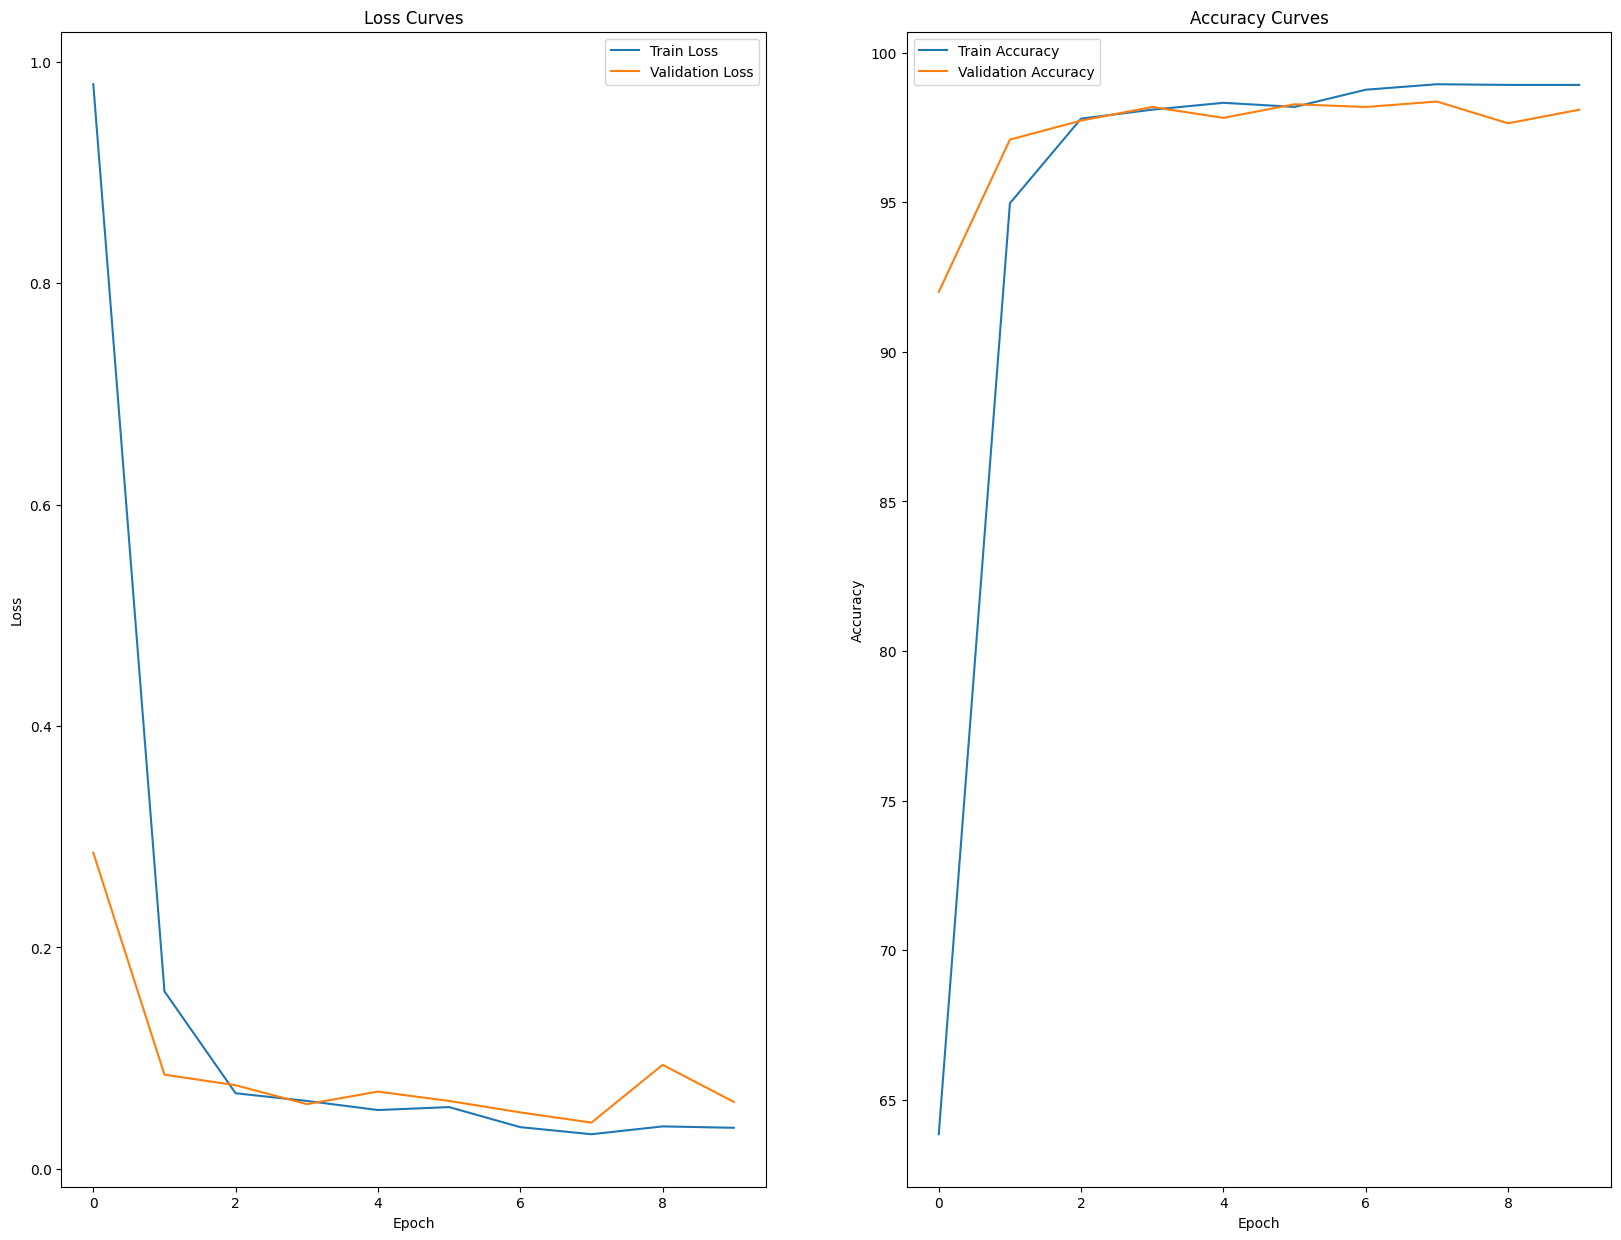

In [21]:
 visualize_results(losss, accs, val_losss, val_accs)

In [22]:

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột

# # Biểu đồ 1 - Training Accuracy
# axs[0].plot(range(1, num_epochs + 1), accs, marker='o')
# axs[0].set_title('Training Accuracy')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Acc')
# axs[0].set_ylim(0, 1)
# axs[0].set_xticks(range(1, num_epochs + 1))
# axs[0].grid()

# # Biểu đồ 2 - Validation Accuracy
# axs[1].plot(range(1, num_epochs + 1), val_accs, marker='o', color='orange')
# axs[1].set_title('Validation Accuracy')
# axs[1].set_xlabel('Epochs')
# axs[0].set_ylabel('Val_acc')
# axs[1].set_ylim(0, 1)
# axs[1].set_xticks(range(1, num_epochs + 1))
# axs[1].grid()

# plt.tight_layout()
# plt.show()

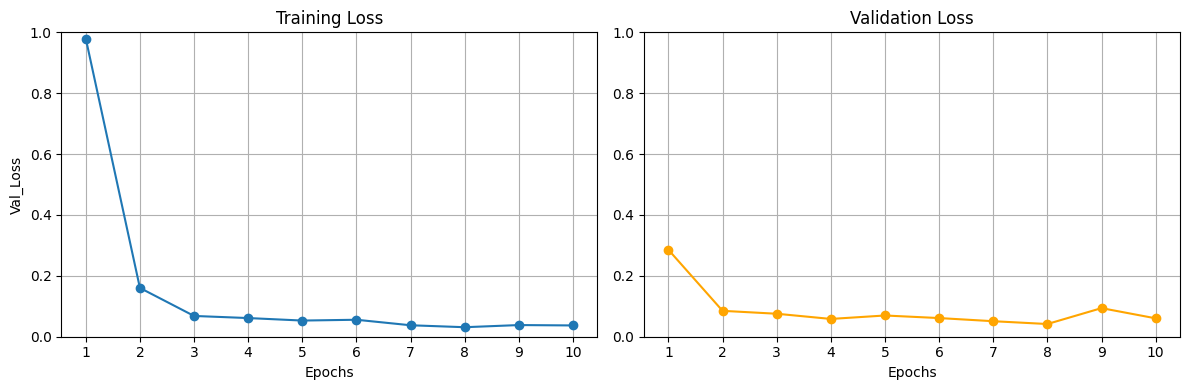

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột

# Biểu đồ 1 - Training Accuracy
axs[0].plot(range(1, num_epochs + 1), losss, marker='o')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0, 1)
axs[0].set_xticks(range(1, num_epochs + 1))
axs[0].grid()

# Biểu đồ 2 - Validation Accuracy
axs[1].plot(range(1, num_epochs + 1), val_losss, marker='o', color='orange')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epochs')
axs[0].set_ylabel('Val_Loss')
axs[1].set_ylim(0, 1)
axs[1].set_xticks(range(1, num_epochs + 1))
axs[1].grid()

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[363   3   2]
 [  0 133   0]
 [ 25   2 319]]


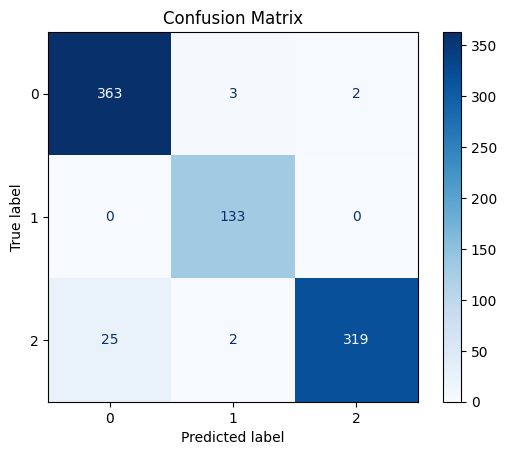

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       368
           1       0.96      1.00      0.98       133
           2       0.99      0.92      0.96       346

    accuracy                           0.96       847
   macro avg       0.96      0.97      0.97       847
weighted avg       0.96      0.96      0.96       847



In [24]:
model.eval()

# Danh sách chứa các nhãn dự đoán và nhãn thực
all_preds = []
all_labels = []

with torch.no_grad():  # Tắt tính toán gradient
    for images, labels in test_loader:  # Giả sử bạn có một DataLoader cho tập kiểm tra
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Lấy nhãn dự đoán
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Chuyển đổi thành mảng NumPy
y_true = np.array(all_labels)
y_pred_classes = np.array(all_preds)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Vẽ ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Tính toán các độ đo
print(classification_report(y_true, y_pred_classes))

In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self._register_hook()
        

    def _register_hook(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))
    
    

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()
        self.model.zero_grad()

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients.detach().cpu().numpy()[0]
        # 
        activations = self.activations.detach().cpu().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
#         weights = np.mean(gradients, axis=(0, 1))
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

In [26]:
def display_gradcam(img, grad_cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [28]:
model1 = HybridViTANFIS(num_classes=num_classes)
state_dict = torch.load('/kaggle/working/vitmobiv3_4_RdC_best.pt')
model1.load_state_dict(state_dict)
model1 = model1.to(device)
model1.eval()

/tmp/ipykernel_30/3354447038.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/vitmobiv3_4_RdC_best.pt')


HybridViTANFIS(
  (cnn_backbone): MobileNetV3Features(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Hardswish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): Id

In [29]:
model.eval()

# Sử dụng model đã huấn luyện và hình ảnh
image_path = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/Late_Blight_11.jpg'  # Đọc ảnh
# /kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/Late_Blight_11.jpg
# /kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/2540_600.jpg
img = Image.open(image_path)
img_resized = img.resize((224, 224))

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),          # Thay đổi kích thước ảnh nếu cần
    transforms.ToTensor(),                  # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh
])

input_tensor = preprocess(img).unsqueeze(0)
class_names = ['early_blight', 'healthy', 'late_blight'] 

LIME

In [31]:
class LimeHybridViTExplainer:
    def __init__(self, model, preprocess_fn, device='cuda'):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.device = device
        self.explainer = lime_image.LimeImageExplainer()

    def get_pil_transform(self):
        def transform_img(img):
            return img.convert('RGB')
        return transform_img

    def get_preprocess_transform(self):
        def preprocess(img):
            return self.preprocess_fn(img).unsqueeze(0)
        return preprocess
    
    def batch_predict(self, images):
        self.model.eval()
        batch = torch.stack([self.preprocess_fn(img) for img in images])
        batch = batch.to(self.device)
        logits = self.model(batch, rm_ft=[28, 32, 45, 60, 66, 68, 86, 87, 95, 105, 106, 108, 109, 110, 111, 113, 117, 127, 140, 141, 163, 166, 172, 173, 175, 190, 196, 205, 225, 260, 266, 276, 280, 285, 289, 299, 309, 327, 331, 337, 338, 354, 358, 365, 370, 371, 378, 
386, 404, 405, 416, 449, 458, 464, 474, 479, 486, 492, 506, 510, 513, 521, 522, 580, 586, 588, 592, 595, 611, 655, 
668, 671, 684, 687, 697, 704, 730, 755, 757, 764])
        probs = nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    def explain(self, image, num_samples=1500, num_feature=4, target_label=None, top_labels=3, hide_color=0, positive_only=True):
        transform_fn = self.get_pil_transform()
        image_transformed = transform_fn(image)

        explanation = self.explainer.explain_instance(
            np.array(image_transformed),
            self.batch_predict,
            top_labels=top_labels,
            hide_color=hide_color,
            num_samples=num_samples
        )

        if target_label is None:
            target_label = explanation.top_labels[0]

        temp, mask = explanation.get_image_and_mask(
            target_label, positive_only=positive_only, num_features=num_feature, hide_rest=True
        )
        
        mask = (mask * 255).astype(np.uint8)
        mask_image = Image.fromarray(mask)
        overlay_image = ImageChops.multiply(image.convert('RGBA'), mask_image.convert('RGBA').point(lambda i: i > 0 and 255))
        result_image = Image.alpha_composite(image.convert('RGBA'), overlay_image)

        return temp, result_image, explanation

    def visualize(self, image, mask):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        ax1.imshow(np.array(image))
        ax1.axis('off')
        ax1.set_title('Original Image')

        ax2.imshow(np.array(mask))
        ax2.axis('off')
        ax2.set_title('LIME ')

        plt.tight_layout()
        plt.show()

# Define the preprocessing functions
def get_pil_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
    ])

def get_preprocess_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [32]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

# Set model to evaluation mode (assumed model variable is defined)
model.eval()

# Read and process the image
image_path = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/Late_Blight_11.jpg'
# /kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/Late_Blight_11.jpg
# /kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/2540_600.jpg
img = Image.open(image_path)
img_resized = pill_transf(img)

Đã tạo xong giải thích và lưu kết quả!


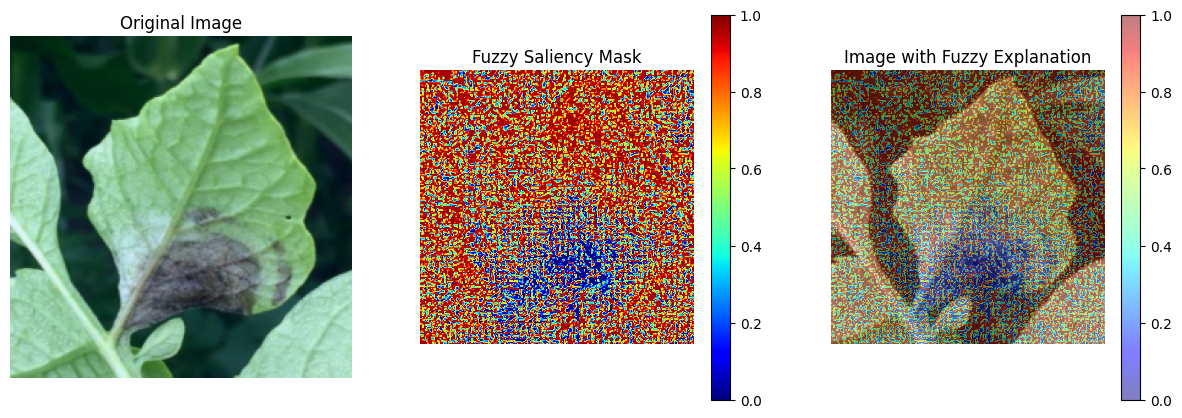

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

class FuzzyXAIExplainer:
    def __init__(self, model, num_fuzzy_rules=5):
        """
        Fuzzy XAI Explainer sử dụng phương pháp suy luận mờ để giải thích mô hình
        
        Args:
            model (nn.Module): Mô hình phân lớp đã được huấn luyện
            num_fuzzy_rules (int): Số lượng quy tắc mờ sử dụng
        """
        self.model = model
        self.num_fuzzy_rules = num_fuzzy_rules
    
    def gaussian_membership(self, x, center, width):
        """
        Hàm thuộc Gaussian để xác định mức độ quan trọng của pixel
        """
        return torch.exp(-((x - center) ** 2) / (2 * width ** 2))
    
    def generate_fuzzy_saliency_mask(self, image, target_class=None):
        """
        Sinh mặt nạ giải thích sử dụng phương pháp mờ
        """
        # Đảm bảo model ở chế độ đánh giá
        self.model.eval()
        
        # Đưa ảnh vào mô hình
        with torch.no_grad():
            original_output = self.model(image)
        
        # Chọn lớp mục tiêu
        if target_class is None:
            target_class = torch.argmax(original_output).item()
        
        # Tạo bản sao có thể tính gradient của ảnh
        image_clone = image.clone().requires_grad_(True)
        
        # Tính toán gradient
        output = self.model(image_clone)
        target_score = output[0, target_class]
        target_score.backward()
        
        # Lấy gradient của ảnh
        gradients = image_clone.grad
        
        # Chuẩn hóa gradient
        gradients = F.relu(gradients)
        saliency = gradients.abs().mean(dim=1)[0].detach().numpy()
        
        # Áp dụng phương pháp mờ
        fuzzy_saliency = self._apply_fuzzy_inference(saliency)
        
        # Chuẩn hóa lại mặt nạ
        fuzzy_saliency = (fuzzy_saliency - fuzzy_saliency.min()) / (fuzzy_saliency.max() - fuzzy_saliency.min())
        
        return fuzzy_saliency
    
    def _apply_fuzzy_inference(self, saliency):
        """
        Áp dụng suy luận mờ để tinh chỉnh mặt nạ
        """
        # Tạo các quy tắc mờ
        fuzzy_rules = []
        for i in range(self.num_fuzzy_rules):
            center = np.percentile(saliency, (i + 1) * (100 / (self.num_fuzzy_rules + 1)))
            width = np.std(saliency) / (self.num_fuzzy_rules + 1)
            
            # Tạo mặt nạ mờ cho mỗi quy tắc
            rule_mask = self._create_fuzzy_mask(saliency, center, width)
            fuzzy_rules.append(rule_mask)
        
        # Kết hợp các quy tắc mờ
        combined_fuzzy_mask = np.mean(fuzzy_rules, axis=0)
        
        return combined_fuzzy_mask
    
    def _create_fuzzy_mask(self, saliency, center, width):
        """
        Tạo mặt nạ mờ dựa trên trung tâm và độ rộng
        """
        fuzzy_mask = np.exp(-((saliency - center) ** 2) / (2 * width ** 2))
        return fuzzy_mask
    
    def visualize_explanation(self, image, fuzzy_mask, save_path=None):
        """
        Trực quan hóa giải thích bằng cách tô màu vùng quan trọng
        """
        # Chuyển ảnh về dạng numpy và chuẩn hóa
        img_numpy = image[0].permute(1, 2, 0).numpy()
        img_numpy = (img_numpy - img_numpy.min()) / (img_numpy.max() - img_numpy.min())
        
        # Áp dụng mặt nạ mờ
        plt.figure(figsize=(15, 5))
        
        # Ảnh gốc
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img_numpy)
        plt.axis('off')
        
        # Mặt nạ mờ
        plt.subplot(1, 3, 2)
        plt.title('Fuzzy Saliency Mask')
        plt.imshow(fuzzy_mask, cmap='jet')
        plt.colorbar()
        plt.axis('off')
        
        # Ảnh kết hợp
        plt.subplot(1, 3, 3)
        plt.title('Image with Fuzzy Explanation')
        plt.imshow(img_numpy)
        plt.imshow(fuzzy_mask, cmap='jet', alpha=0.5)
        plt.colorbar()
        plt.axis('off')
        
        # Lưu hoặc hiển thị
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

def load_and_preprocess_image(image_path, image_size=224):
    """
    Load và tiền xử lý ảnh từ đường dẫn
    """
    # Định nghĩa transform
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load ảnh
    image = Image.open(image_path).convert('RGB')
    
    # Áp dụng transform
    image_tensor = transform(image)
    
    # Thêm batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

def process_and_explain_image(model, image_path, save_path=None):
    """
    Xử lý ảnh và tạo giải thích sử dụng Fuzzy XAI
    """
    # Load và tiền xử lý ảnh
    image_tensor = load_and_preprocess_image(image_path)
    
    # Khởi tạo Fuzzy XAI Explainer
    fuzzy_explainer = FuzzyXAIExplainer(model, num_fuzzy_rules=5)
    
    # Tạo mặt nạ giải thích
    fuzzy_mask = fuzzy_explainer.generate_fuzzy_saliency_mask(image_tensor)
    
    # Trực quan hóa kết quả
    fuzzy_explainer.visualize_explanation(
        image_tensor,
        fuzzy_mask,
        save_path=save_path if save_path else 'fuzzy_xai_explanation.png'
    )
    
    return fuzzy_mask

# Ví dụ sử dụng:
if __name__ == "__main__":
    # Đường dẫn đến ảnh
    image_path = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/test/late_blight/2540_600.jpg'
    
    # Khởi tạo model (sử dụng HybridViTANFIS model của bạn)
    model = HybridViTANFIS(num_classes=2)
    
    # Load weights nếu cần
    # model.load_state_dict(torch.load('path_to_model_weights.pth'))
    
    # Xử lý ảnh và tạo giải thích
    explanation_mask = process_and_explain_image(
        model,
        image_path,
        save_path='fuzzy_explanation_result.png'
    )
    
    print("Đã tạo xong giải thích và lưu kết quả!")
